In [10]:
import json, os, pathlib as p
import numpy as np
import nibabel as nib
import nibabel.processing as nibpro
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tqdm import tqdm
import subprocess, shlex



In [11]:
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
assert DATA_DIR.exists(), f"Folder not found: {DATA_DIR}"
DATA_DIR

PosixPath('/Users/al1612le/data/bobsrepository')

In [12]:
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))

In [13]:
nii_path = t2_files[0]
img = nib.load(str(nii_path))
vol = img.get_fdata()
hdr = img.header
voxel_size = hdr.get_zooms()
#print(hdr)
#print(img.affine)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 182 218  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.4:ddd0a010'
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [-1

<OrthoSlicer3D: /Users/al1612le/data/bobsrepository/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz (182, 218, 182)>

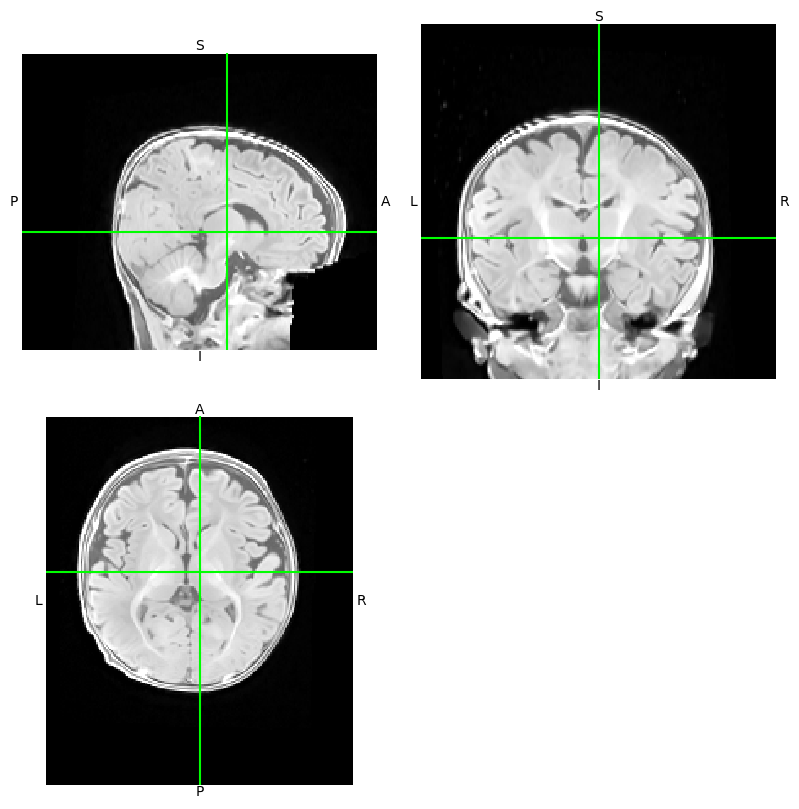

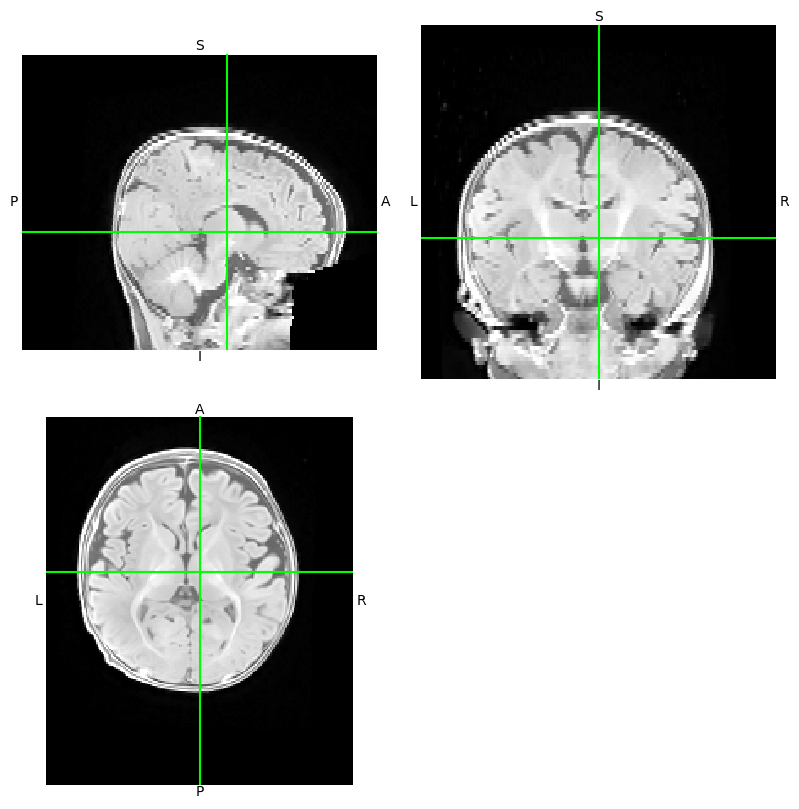

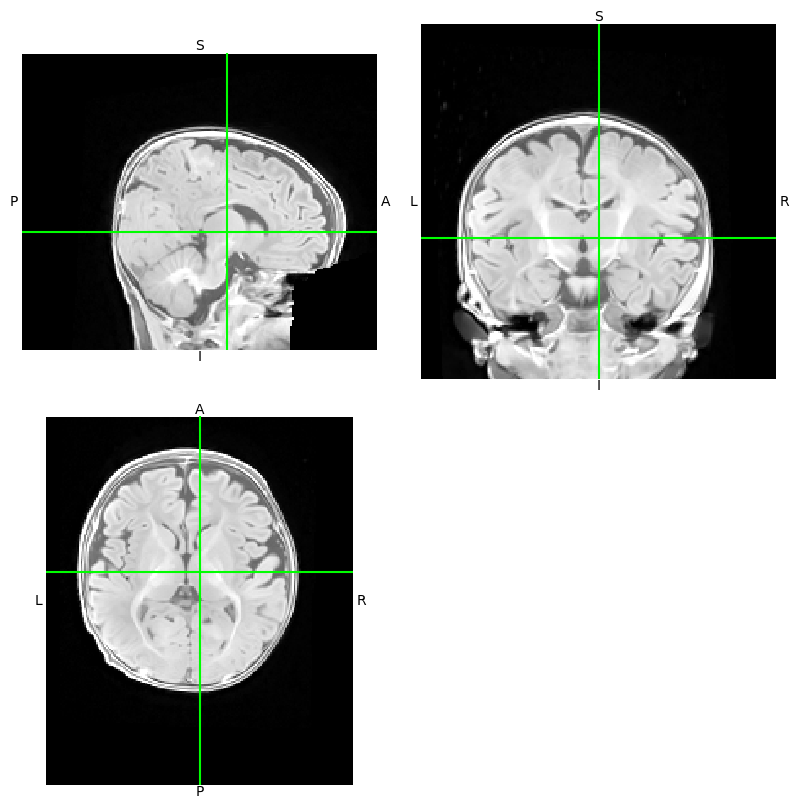

In [7]:
"""
one_slice = vol[:,:,50]
plt.imshow(one_slice)
"""
smore_files = sorted(DATA_DIR.rglob("*smore4.nii.gz"))
smore_img = nib.load(str(smore_files[0]))
smore_img.orthoview()

lr_files = sorted(DATA_DIR.rglob("*LR.nii.gz"))
lr_img = nib.load(str(lr_files[0]))
lr_img.orthoview()

print(lr_img.header)

img.orthoview()

<OrthoSlicer3D: (182, 218, 91)>

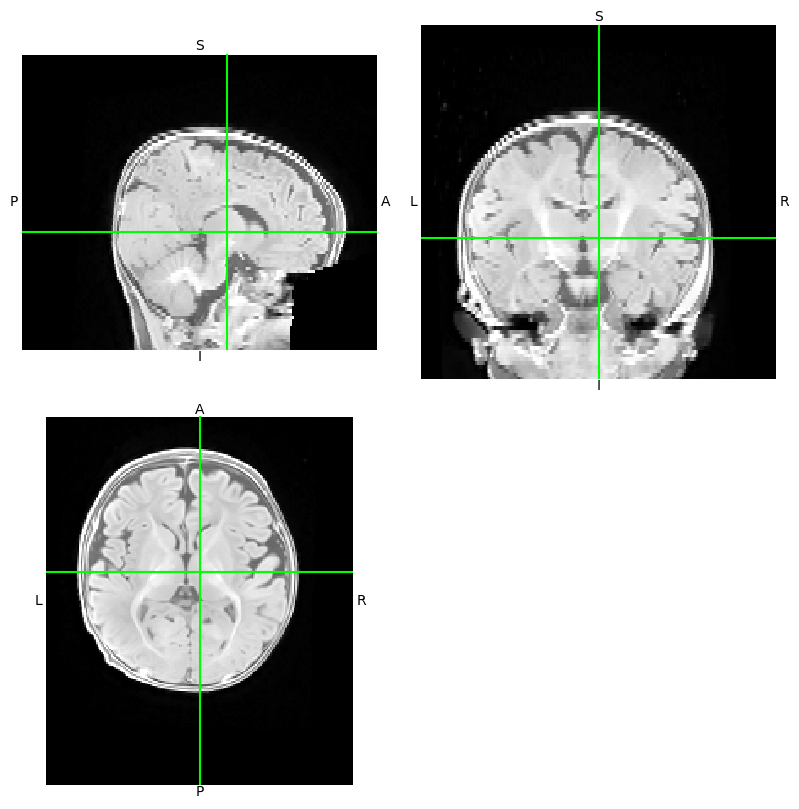

In [ ]:
#DOWNSAMPLE TO ANISOTROPIC (1x1x2)
down_img = img.slicer[:, :, ::2]
down_img.shape
down_img.orthoview()
down_img.affine


In [8]:
iso = nibpro.resample_to_output(down_img, voxel_sizes=(1.0, 1.0, 1.0))

In [47]:
iso.shape
print(down_img.affine)
print(iso.affine)

[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
[[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


<OrthoSlicer3D: (182, 218, 181)>

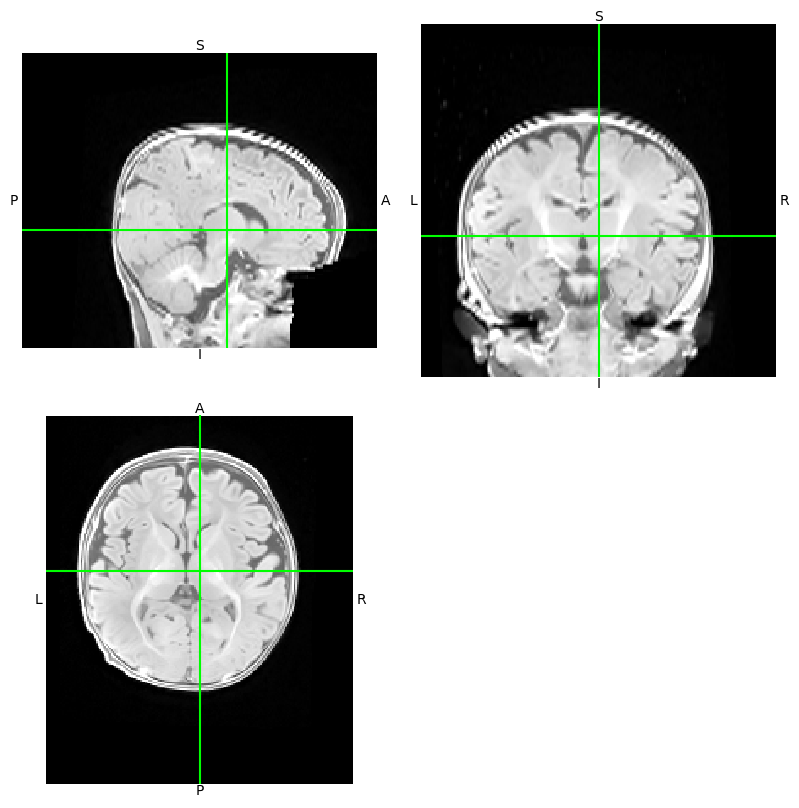

In [10]:
iso.orthoview()

In [92]:
#GENERATE DOWNSAMPLED LR MRI IN AXIAL DIRECTION
#saves LR t1w and t2w in lr folder
#only in axial!


    
for i in range(len(t2_files)):
    nii_path = t2_files[i]
    img = nib.load(str(nii_path))
    lr_img = img.slicer[:, :, ::2]
    
    split_nii_path = os.path.split(nii_path) #hur vet jag var split sker?
    lr_path = p.Path(split_nii_path[0])
    lr_path = lr_path/"lr"
    lr_path.mkdir(exist_ok=True)
    lr_name = split_nii_path[1].replace(".nii.gz", "_LR.nii.gz")

    nib.save(lr_img, str(lr_path / lr_name))






In [82]:
#remove all lr files
"""
from pathlib import Path

candidates = [p for p in DATA_DIR.rglob("*_LR.nii.gz") if p.name.endswith("_LR.nii.gz")]

deleted = 0
for p in candidates:
    try:
        p.unlink()
        deleted += 1
    except Exception as e:
        print("Failed to delete:", p, "->", e)

print(f"Deleted {deleted} files permanently.")
"""

Deleted 71 files permanently.


In [5]:
#SMORE TEST

lr_files = sorted(DATA_DIR.rglob("*T1w_LR.nii.gz")) 
print("Found", len(lr_files), "LR files")

Found 71 LR files


In [ ]:
def run(cmd):
    print(cmd)
    return subprocess.run(shlex.split(cmd), check=True)

for f in lr_files:
    out_dir = f.parent / "smore_out"
    out_dir.mkdir(exist_ok=True, parents=True)
    cmd = f"run-smore --in-fpath {f} --out-dir {out_dir}"
    # Example of adding options:
    # cmd += " --gpu-id 0"
    # cmd += " --slice-thickness 4.0"
    run(cmd)

run-smore --in-fpath /Users/al1612le/data/bobsrepository/sub-116056/ses-3mo/anat/lr/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w_LR.nii.gz --out-dir /Users/al1612le/data/bobsrepository/sub-116056/ses-3mo/anat/lr/smore_out


/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/smore/train.py:108: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


========== BEGIN TRAINING ==========
GPU index not provided or no GPU support currently available.
!!! Running on CPU !!!
Parsing image file...
	Elapsed time: 0.0488s
Gathering data augmentations (flips and transposition in-plane)...
	Elapsed time: 0.0204s
Padding image out to extract patches correctly...
	Elapsed time: 0.0362s
Generating (weighted) random patch centers..
	Elapsed time: 0.8814s

========== TRAINING NETWORK ==========



  0%|          | 0/832000 [00:00<?, ?it/s]/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/smore/train.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 832000/832000 [13:49:48<00:00, 16.71it/s, loss=0.0028]    



	Elapsed time to finish training: 49788.1017s


/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
  0%|          | 0/182 [00:00<?, ?it/s]/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/smore/test.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  1%|          | 2/182 [00:00<00:09, 18.68it/s]

========== BEGIN PREDICTION ==========
GPU index not provided or no GPU support currently available.
!!! Running on CPU !!!
Super-resolving at 0 degrees: 1/2


  0%|          | 0/218 [00:00<?, ?it/s]

	Elapsed time: 6.7629s
Super-resolving at 90 degrees: 2/2


100%|██████████| 218/218 [00:05<00:00, 37.25it/s]


	Elapsed time: 5.8605s
Saving image...


DONE
Elapsed time: 13.2033s

	Written to: /Users/al1612le/data/bobsrepository/sub-116056/ses-3mo/anat/lr/smore_out/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w_LR/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w_LR_smore4.nii.gz

========== END PREDICTION ==========
run-smore --in-fpath /Users/al1612le/data/bobsrepository/sub-116845/ses-3mo/anat/lr/sub-116845_ses-3mo_space-INFANTMNIacpc_T1w_LR.nii.gz --out-dir /Users/al1612le/data/bobsrepository/sub-116845/ses-3mo/anat/lr/smore_out


/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/smore/train.py:108: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


========== BEGIN TRAINING ==========
GPU index not provided or no GPU support currently available.
!!! Running on CPU !!!
Parsing image file...
	Elapsed time: 0.0296s
Gathering data augmentations (flips and transposition in-plane)...
	Elapsed time: 0.0199s
Padding image out to extract patches correctly...
	Elapsed time: 0.0357s
Generating (weighted) random patch centers..
	Elapsed time: 0.8996s

========== TRAINING NETWORK ==========



  0%|          | 0/832000 [00:00<?, ?it/s]/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/smore/train.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/Users/al1612le/mri-sr-bob/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 512/832000 [00:55<8:53:31, 25.97it/s, loss=0.0434] 

(182, 218, 182)
(64, 64, 64)


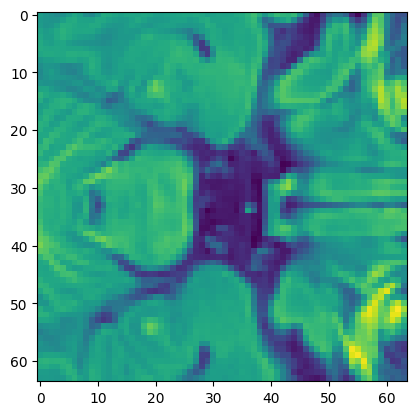

In [ ]:
#Generate random patches

#LR anisotropic image upsampled to LR isotropic with spline interpol
iso_LR = nibpro.resample_from_to(down_img, ((182,218,182), iso.affine))
iso_LR.shape



128


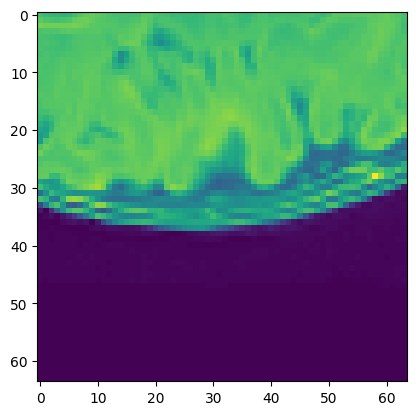

In [76]:
# img = .nii format
# affine transformation?
# transform back to .nii format?
# within borders!

def extract_random_3Dpatches(img, patch_size = (64,64,64), n_patches = 128):
    
    rng = np.random.default_rng(7)
    patches = []
    coord = []
    img_affine = img.affine
    vol = img.get_fdata()

    x, y, z = vol.shape #omvänt med z,y,x?
    px, py, pz = patch_size

    for i in range(n_patches):
        x0 = rng.integers(0, x - px)
        y0 = rng.integers(0, y - py)
        z0 = rng.integers(0, z - pz)

        patch = vol[x0:x0+px, y0:y0+py, z0:z0+pz]
        patches.append(patch)
        coord.append((x0,y0,z0))

    return patches, coord, img_affine

#test
p, c, a = extract_random_3Dpatches(iso_LR)
print(len(c))
plt.imshow(p[0][:,:,1])


(111, 96, 80) [ 20. -30.   8.] [111.  96.  80.]
[70. 96. 80.]
70


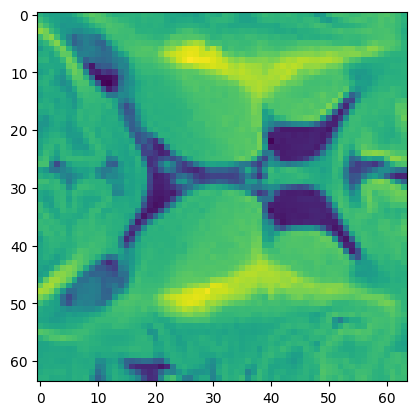

In [77]:
#extract same slices from HR and LR:
inv_a = np.linalg.inv(a)
c_ref = nib.affines.apply_affine(a, c[0])
c_test = nib.affines.apply_affine(inv_a, c_ref)
print(c[0], c_ref, c_test)

inv_hr_a = np.linalg.inv(img.affine)
c_hr = nib.affines.apply_affine(inv_hr_a, c_ref)
print(c_hr)

x, y, z = c_hr
x = int(x)
y = int(y)
z = int(z)
print(x)
vol = img.get_fdata()
patch = vol[x:x+64,y:y+64,z:z+64]
plt.imshow(patch[:,:,1])



[[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]] [[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]] [[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
[ 20. -30.   9.]


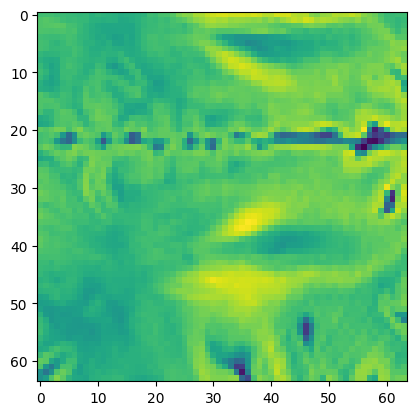

In [103]:
def extract_3Dpatches(LR_img, HR_img, patch_size = (64,64,64), n_patches = 128):
    
    rng = np.random.default_rng(7)
    LR_patches = []
    HR_patches = []
    ref_coords = []
    LR_vol = LR_img.get_fdata()
    HR_vol = HR_img.get_fdata() #if sats om hr lr olika stora?
    LR_aff = LR_img.affine
    HR_aff = HR_img.affine
    HR_inv_aff = np.linalg.inv(HR_aff)

    x, y, z = LR_vol.shape #omvänt med z,y,x?
    px, py, pz = patch_size

    for i in range(n_patches):
        x0 = rng.integers(0, x - px)
        y0 = rng.integers(0, y - py)
        z0 = rng.integers(0, z - pz)

        patch = LR_vol[x0:x0+px, y0:y0+py, z0:z0+pz]
        LR_patches.append(patch)

        ref_coord = nib.affines.apply_affine(LR_aff, (x0,y0,z0))
        
        #HR coordinates
        x0, y0, z0= nib.affines.apply_affine(HR_inv_aff, ref_coord)
        x0 = int(x0)
        y0 = int(y0)
        z0 = int(z0)
        patch = HR_vol[x0:x0+px, y0:y0+py, z0:z0+pz]
        HR_patches.append(patch)

        ref_coords.append(ref_coord)

    return LR_patches, HR_patches, ref_coords

img #original HR image
aniso_img = nibpro.resample_to_output(img, (1.0, 1.0, 2.0))
iso_img = nibpro.resample_to_output(aniso_img, (1.0, 1.0, 1.0))
print(iso_img.affine, aniso_img.affine, img.affine)
LR_patches, HR_patches, ref_coords = extract_3Dpatches(iso_img, img)

print(ref_coords[0])
plt.imshow(LR_patches[1][:,:,1]) #fel affine?
plt.imshow(HR_patches[1][:,:,1])

[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]] [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


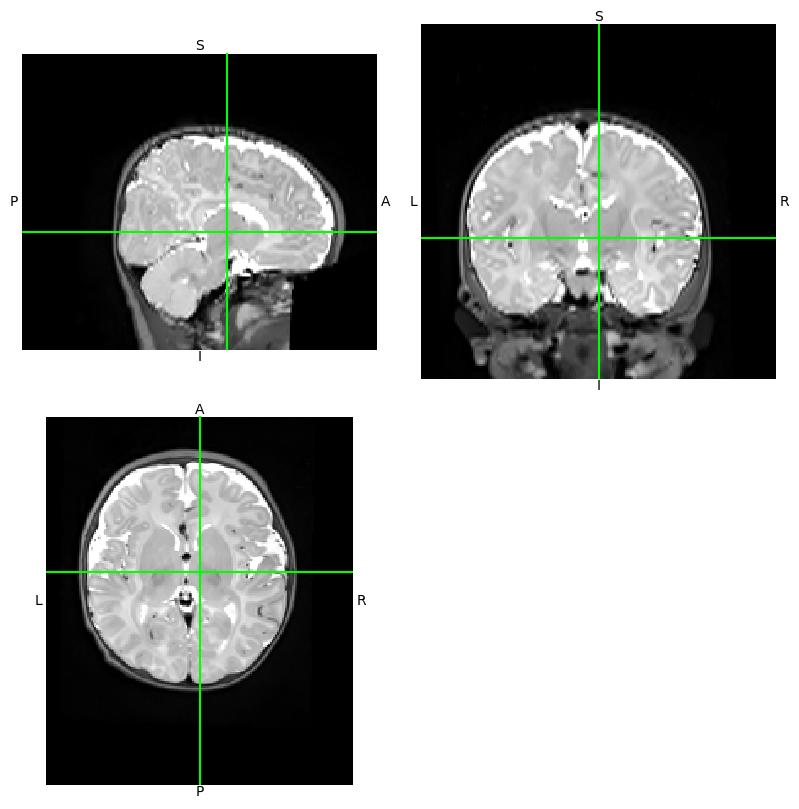

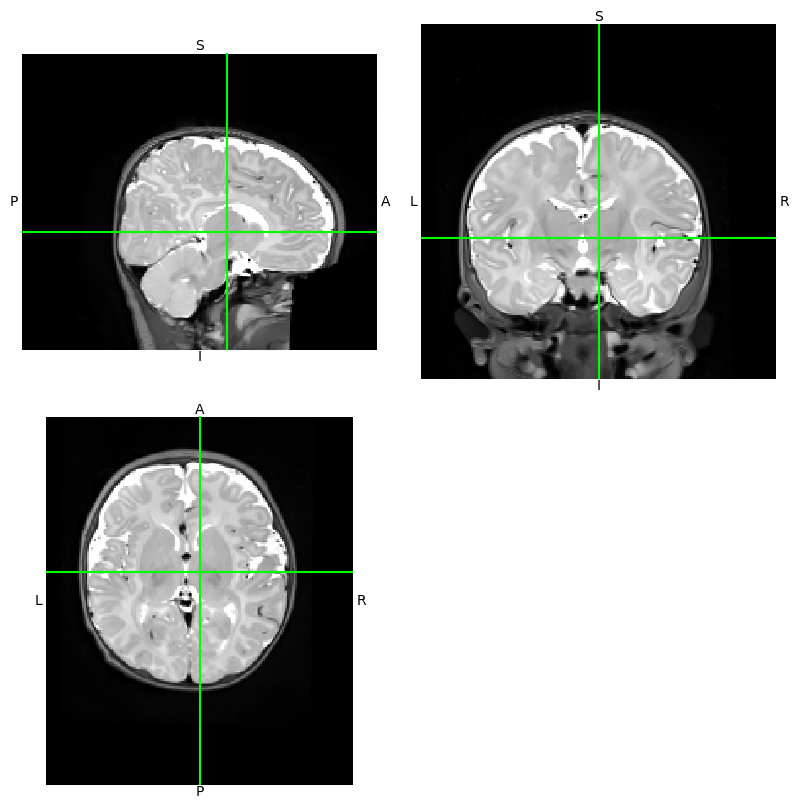

In [18]:
#Compare HR and LR:
hr_img = img

hr_data = hr_img.get_fdata()
hr_aff = hr_img.affine

downsample_factor = 2
lr_data = hr_data[:, :, ::downsample_factor]

# Update the affine: scale the voxel sizes
lr_aff = hr_aff.copy()
lr_aff[:3, :3] *= downsample_factor  # scale the voxel size
lr_img = nib.Nifti1Image(lr_data, lr_aff)

# Calculate zoom factors to match original shape
zoom_factors = np.array(hr_data.shape) / np.array(lr_data.shape)

# Upsample with interpolation
upsampled_data = zoom(lr_data, zoom_factors, order=3)  # order=3: cubic interpolation

# Use the original affine for the upsampled image
upsampled_img = nib.Nifti1Image(upsampled_data, hr_aff)


upsampled_img.orthoview()
hr_img.orthoview()
print(hr_aff, lr_aff)

In [ ]:
# ref_img is your chosen reference image (e.g., the HR image)
aligned_img = nibpro.resample_from_to(moving_img, ref_img)


LR_img = nibpro.resample_to_output(HR_img, (1.0, 1.0, 2.0))
LR_img.orthoview()
HR_img.orthoview()

LR_img_iso = nibpro.resample_from_to(LR_img, ((182,218,182), HR_aff))
LR_img_iso.orthoview()

#print(LR_img_iso.affine, HR_aff, LR_img.affine)


In [8]:
# create img_dir with all T1 HR-LR pairs
for i in range(len(t1_files)):
    nii_path = t1_files[i]
    hr_img = nib.load(str(nii_path))
    aniso_img = nibpro.resample_to_output(hr_img, (1.0,1.0,2.0))
    lr_img = nibpro.resample_to_output(aniso_img, (1.0,1.0,1.0))
    

    split_nii_path = os.path.split(nii_path) #hur vet jag var split sker?
    hr_name = split_nii_path[1].replace(".nii.gz", "_HR.nii.gz")
    lr_name = split_nii_path[1].replace(".nii.gz", "_LR.nii.gz")

    img_path = p.Path.home()/"T1-HR-LR-pairs"
    img_path.mkdir(exist_ok=True)

    nib.save(hr_img, str(img_path / hr_name))
    nib.save(lr_img, str(img_path / lr_name))

In [9]:
#create csv file with HR-LR names
import csv

from pathlib import Path

img_dir = Path.home() / "T1-HR-LR-pairs"
hr_files = sorted(img_dir.glob("*_HR.nii.gz"))
lr_files = sorted(img_dir.glob("*_LR.nii.gz"))

# Match HR and LR by base name (before _HR/_LR)
pairs = []
for hr in hr_files:
    base = hr.name.replace("_HR.nii.gz", "")
    lr = img_dir / f"{base}_LR.nii.gz"
    if lr.exists():
        pairs.append((hr.name, lr.name))

csv_path = img_dir / "t1_hr_lr_pairs.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["HR", "LR"])
    writer.writerows(pairs)

print(f"Wrote {len(pairs)} pairs to {csv_path}")

Wrote 71 pairs to /Users/al1612le/T1-HR-LR-pairs/t1_hr_lr_pairs.csv
